In [1]:
from qcodes_contrib_drivers.drivers.QDevil import QDAC2
from zhinst.qcodes import ZISession
from time import sleep
import pyvisa as visa
import numpy as np
import matplotlib.pyplot as plt

# instrument connection

In [2]:
# QDACII connection
qdac_addr = '192.168.0.198'
qdac = QDAC2.QDac2('QDAC', visalib='@py', address=f'TCPIP::{qdac_addr}::5025::SOCKET')

Connected to: QDevil QDAC-II (serial:200, firmware:11-1.21) in 0.17s


In [3]:
# ZI MFLI lockin connection
mfli_addr = "192.168.0.220"
DEVICE_ID = "dev30577"
session = ZISession(mfli_addr)
device = session.connect_device(DEVICE_ID)
daq = session.modules.daq
sweeper = session.modules.sweeper

In [4]:
qdac.reset() # reset QDACII

voltages = np.linspace(-0.4, 0.4, 101)
dwell_s  = 200e-3                     
repeat=1000

dc_ch2 = qdac.ch02.dc_sweep(
    repetitions=repeat,
    stepped=True,
    start_V=-1,
    stop_V=1,
    points=11,
    dwell_s=dwell_s,
)  

step_trig = dc_ch2.step_end_marker()   

qdac.ext1.width_s(dwell_s / 2)             
qdac.ext1.polarity('norm')                    
qdac.ext1.source_from_trigger(step_trig)  
qdac.ext1.delay_s(0.1*dwell_s)  

In [5]:
qdac.start_all()  

In [6]:
def basic_mfli_setup(mfli, V_exc, frequency):
    OUT_CH   = 0  
    OSC      = 0   
    DEMOD    = 0  # demodulator 1 

    with mfli.set_transaction():
        # Output setup             
        mfli.sigouts[OUT_CH].on(True)
        mfli.sigouts[OUT_CH].enables[1].value(True)

        # Set output amplitudes for both paths
        mfli.sigouts[OUT_CH].amplitudes[1].value(V_exc)    
        
        # Set frequency of oscillator
        mfli.oscs[OSC].freq(frequency)  # Set frequency
        
        # Input setup
        mfli.sigins[0].range(0.1)  # This may need to be adjusted based on the input signal
        mfli.demods[DEMOD].enable(True)
        mfli.demods[DEMOD].oscselect(OSC)
        mfli.demods[DEMOD].adcselect(0)
        mfli.demods[DEMOD].order(4)
        mfli.demods[DEMOD].timeconstant(0.01)

    return mfli

In [7]:
V_exc = 0.2
frequency = 1e3  # Frequency in Hz
OUT_CH   = 0  
OSC      = 0   
DEMOD    = 0  # demodulator 1 

with device.set_transaction():
    # Output setup             
    device.sigouts[OUT_CH].on(True)
    device.sigouts[OUT_CH].enables[1].value(True)

    # Set output amplitudes for both paths
    device.sigouts[OUT_CH].amplitudes[1].value(V_exc)    
    # Set frequency of oscillator
    device.oscs[OSC].freq(frequency) 
    
    # Input setup
    device.sigins[0].range(0.1)  # This may need to be adjusted based on the input signal
    device.demods[DEMOD].enable(True)
    device.demods[DEMOD].oscselect(OSC)
    device.demods[DEMOD].adcselect(0)
    device.demods[DEMOD].order(4)
    device.demods[DEMOD].timeconstant(0.01)
    device.demods[DEMOD].trigger(0) # 0: continuous, 1: rise 2: fall


In [8]:
device.demods[0].sample()

{'timestamp': array([19540185365], dtype=uint64),
 'x': array([0.00143849]),
 'y': array([-4.40051534e-05]),
 'frequency': array([1000.00000003]),
 'phase': array([3.32097253]),
 'dio': array([0], dtype=uint32),
 'trigger': array([0], dtype=uint32),
 'auxin0': array([0.00066147]),
 'auxin1': array([-0.00132308])}

## continous record
https://github.com/zhinst/labone-api-examples/blob/release-25.04/hf2-mf-uhf/python/example_data_acquisition_continuous.md

In [9]:
daq.device(device)

In [10]:
demod_path = f"/{DEVICE_ID}/demods/0/sample"
signal_paths = []
signal_paths.append(demod_path + ".x")  # The demodulator X output.
signal_paths.append(demod_path + ".y")  # The demodulator Y output.

In [11]:
total_duration = 5 # Time in seconds for the aquisition.
module_sampling_rate = 30000  # Number of points/second.
burst_duration = 0.2  # Time in seconds for each data burst/segment.
num_cols = int(np.ceil(module_sampling_rate * burst_duration))
num_rows = int(3)
num_bursts = int(np.ceil(total_duration / burst_duration))

In [12]:
device.demods[DEMOD].enable(True)
daq.type("continuous")
daq.grid.mode('linear')
daq.count(num_bursts)
daq.duration(burst_duration)
daq.grid.cols(num_cols)
#daq.grid.rows(num_rows)

In [13]:
data = {}
for signal_path in signal_paths:
    print("Subscribing to ", signal_path)
    daq.subscribe(signal_path)
    data[signal_path] = []

Subscribing to  /dev30577/demods/0/sample.x
Subscribing to  /dev30577/demods/0/sample.y


In [14]:
clockbase = device.clockbase()
print("Clockbase: ", clockbase)

Clockbase:  60000000.0


In [15]:
#filename = "Example_Data_Acquisition_Continous"
#daq.save.filename(filename)
#daq.save.fileformat("hdf5")  


{'/awgcontrol': array([0], dtype=int64), '/bandwidth': array([0.]), '/bitmask': array([1], dtype=int64), '/bits': array([1], dtype=int64), '/buffercount': array([3], dtype=int64), '/buffersize': array([0.2]), '/clearhistory': array([0], dtype=int64), '/count': array([25], dtype=int64), '/delay': array([-0.001]), '/device': ['dev30577'], '/duration': array([0.2]), '/edge': array([1], dtype=int64), '/enable': array([1], dtype=int64), '/endless': array([0], dtype=int64), '/eventcount/mode': array([1], dtype=int64), '/fft/absolute': array([0], dtype=int64), '/fft/powercompensation': array([0], dtype=int64), '/fft/window': array([1], dtype=int64), '/findlevel': array([0], dtype=int64), '/flags': array([8], dtype=int64), '/forcetrigger': array([0], dtype=int64), '/grid/cols': array([6000], dtype=int64), '/grid/direction': array([0], dtype=int64), '/grid/mode': array([2], dtype=int64), '/grid/overwrite': array([0], dtype=int64), '/grid/repetitions': array([1], dtype=int64), '/grid/rowrepetiti

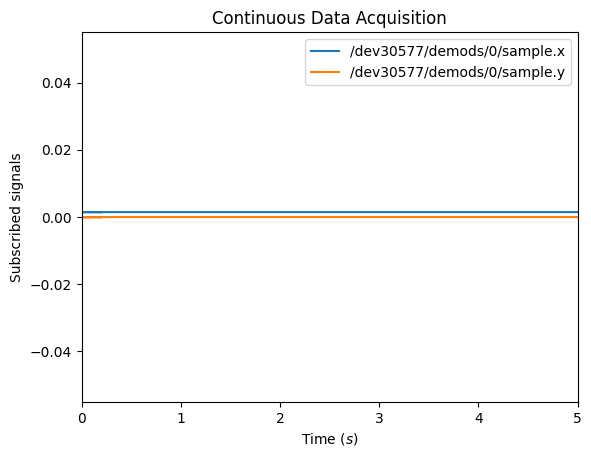

In [16]:
import time
do_plot = True

clockbase = device.clockbase()
if do_plot:
    timestamp0 = None
    max_value = None
    min_value = None
    fig, axis = plt.subplots()
    axis.set_xlabel("Time ($s$)")
    axis.set_ylabel("Subscribed signals")
    axis.set_xlim([0, total_duration])
    lines = [axis.plot([], [], label=path)[0] for path in signal_paths]
    axis.legend()
    axis.set_title("Continuous Data Acquisition")
    plt.ion()


def process_data(raw_data):
    global timestamp0, lines, max_value, min_value
    for i, signal_path in enumerate(signal_paths):
        # Loop over all the bursts for the subscribed signal. More than
        # one burst may be returned at a time, in particular if we call
        # read() less frequently than the burst_duration.
        for signal_burst in raw_data.get(signal_path.lower(), []):
            # Convert from device ticks to time in seconds.
            # value = signal_burst["value"][0, :]
            value = signal_burst[1][0]
            data[signal_path].append(value)
            if do_plot:
                max_value = max(max_value, max(value)) if max_value else max(value)
                min_value = min(min_value, min(value)) if min_value else min(value)
                #axis.set_ylim(1.3e-3, 1.5e-3)
                timestamp0 = (
                    timestamp0 if timestamp0 else signal_burst[0]['createdtimestamp']
                )
                t = (signal_burst[0]['changedtimestamp'] - timestamp0) / clockbase
                lines[i].set_data(
                    np.concatenate((lines[i].get_xdata(), signal_burst[2]), axis=0),
                    np.concatenate((lines[i].get_ydata(), value), axis=0),
                )
    if do_plot:
        fig.canvas.draw()

# Start recording data.
daq.execute()
# Record data in a loop with timeout.
timeout = 3 * total_duration
start = time.time()

while not daq.finished():
    t0_loop = time.time()
    if time.time() - start > timeout:
        raise Exception(
            f"Timeout after {timeout} s - recording not complete."
            "Are the streaming nodes enabled?"
            "Has a valid signal_path been specified?"
        )
    raw_data = daq.read()
    print(raw_data)
    process_data(raw_data)
    
    time.sleep(max(0, burst_duration - (time.time() - t0_loop)))
# There may be new data between the last read() and calling finished().
raw_data = daq.read()
process_data(raw_data)

## trigger 